# Analysis of neutralization assays

This notebook is to analyze neutralization assay data. 
In brief, we rescued various influenza viruses carrying PB1-flank-eGFP and measured % infectivity after neutralization of these GFP viruses with antibody. We measure infectivity by GFP signal in infected cells on a Tecan plate reader ~16-18 h after infection.

In [1]:
import os
import subprocess
import glob
import math
import time
import pandas as pd
import numpy as np
from colour import Color
from scipy.optimize import curve_fit
import matplotlib
import matplotlib.lines as mlines
matplotlib.use("Pdf")
print ("Using matplotlib version {0}".format(matplotlib.__version__))
from matplotlib.ticker import MaxNLocator
import pylab as plt
from IPython.display import Image, display, HTML
import dms_tools2
from dms_tools2.ipython_utils import showPDF

inputdir = './platereaderdata/'

/home/jmlee34/.local/lib/python3.4/site-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


Using matplotlib version 2.0.2


## Plotting functions to create neutralization curve plots

In [56]:
def sigmoid(x, x0, k):
    '''from example use of scipy.optimize.curve_fit found at https://gist.github.com/andrewgiessel/5684769'''
    # forces 0% infectivity
    y = 1 / (1 + np.exp(-k*(x-x0)))
    return y

def sigmoid2(x, x0, k, a):
    '''from example use of scipy.optimize.curve_fit found at https://gist.github.com/andrewgiessel/5684769'''
    # additional parameter for bottoming out above or below zero
    y = 1 / (1 + np.exp(-k*(x-x0)))+a
    return y

def expo(x, a, b, c):
    y = a*np.exp(-b*x)-c
    return y

def PlotNeutralizationCurves(data, x_datalabel, y_datalabels, outfile, 
                             color_cycle=['k','k','k','k','k','k'],
                             style_cycle=['solid','solid','solid','solid','solid','solid'],
                             fit_cycle=[sigmoid,sigmoid,sigmoid,sigmoid,sigmoid,sigmoid],
                             fmt_cycle = ['o','o','o','o','o','o'],
                             linewidth=2, fit_curve = False, x_lim = None, y_lim = None, figsize=(5,4),
                             verbose=False, x_label_override=False, alpha=1, markersize=9, mew=2,
                             legend_placement_override=False, no_legend=False,
                             legendfontsize=14, vlines = None):
    '''
    *data* is a dataframe of mAb concentrations and resulting fraction infectivity/stdev. 
    The mAb concentrations have column header *x_datalabel*, and the 
    fractional infectivity and stdev of fractional infectivity should have column headers of
    the items of the list *y_datalabels* followed by '_avg' and '_std', respectively.
    '''
        
    f, ax = plt.subplots()
    handles = [] # proxy artists for the legend to show a single legend entry representing the data (marker) and the curve fit (line)
    
    for i,y_datalabel in enumerate(y_datalabels):
        if fit_curve:
            try: 
                popt, pcov = curve_fit(fit_cycle[i], data[x_datalabel], data[y_datalabel + '_avg'])
                minlog = math.log10(min(data[x_datalabel]))
                maxlog = math.log10(max(data[x_datalabel]))
                xcurve = np.logspace(minlog, maxlog, num=100)
                ycurve = fit_cycle[i](xcurve, *popt)
                ax.plot(xcurve, ycurve, color=color_cycle[i], linewidth=linewidth, linestyle=style_cycle[i], label=y_datalabel, alpha=alpha)
                
                if verbose:
                    print ("\n\ncurve-fitting info for ", y_datalabel)
                    print ("fit parameters for curve: ", popt)
                    if fit_cycle[i] == expo:
                        (a, b, c) = popt
                        ic50 = np.log((0.5+c)/a)/-b
                        print ("expo fit curve was used; here is the IC50 calculated from the fit parameters: ", ic50)
                    elif fit_cycle[i] == expo_fixed_top:
                        (b, c) = popt
                        ic50 = np.log((0.5+c)/1.0)/-b
                        print ("expo fit fixed top curve was used; here is the IC50 calculated from the fit parameters: ", ic50)
            except:
                print ("Threw an exception during fitting {0} curve for {1}".format(fit_cycle[i], y_datalabel))
                        
        ax.errorbar(data[x_datalabel], data[y_datalabel + '_avg'], 
                    yerr=data[y_datalabel + '_std'], 
                    color=color_cycle[i], fmt=fmt_cycle[i], 
                    capthick=2, elinewidth=2, markersize=markersize, capsize=markersize/1.5,
                    label=y_datalabel, mew=mew)
        
        custom_handle = mlines.Line2D([], [], color=color_cycle[i], marker=fmt_cycle[i], 
                                      markersize=1.*markersize, linestyle=style_cycle[i], label=y_datalabel,
                                      linewidth=1.*linewidth, mew=mew)
        handles.append(custom_handle)
    
    if x_lim:
        ax.set_xlim(x_lim)
    else:
        ax.set_xlim([4E-3,100])
    ax.set_xscale("log")
    
    if y_lim:
        ax.set_ylim(y_lim)
    else:
        ax.set_ylim([-0.05,1.2])
        
    plt.yticks([0.00, 0.25, 0.5, 0.75, 1.00], ['0', '0.25', '0.50', '0.75', '1.0'])
    
    spineOffset = {'left': 8, 'bottom': 8}    
    [spine.set_position(('outward',spineOffset[loc])) if loc in ['left','bottom'] else spine.set_color('none') for loc, spine in ax.spines.items() ] 
    plt.rcParams['xtick.direction'] = 'out'
    plt.rcParams['ytick.direction'] = 'out'
    ax.xaxis.set(ticks_position = 'bottom')
    ax.yaxis.set(ticks_position = 'left')
    plt.tick_params(axis='both', which='major', labelsize=16, width=2)
    
    ax.minorticks_off()
    
    if x_label_override:
        plt.xlabel(x_label_override, fontsize=19)
    else:
        plt.xlabel('$\mu$g/ml', fontsize=19)

    plt.ylabel('fraction infectivity', fontsize=19)
    
    if vlines:
        for xc in vlines:
            plt.axvline(x=xc, linestyle = 'dashed', linewidth=3, color='#CC79A7', dashes=(2, 3))
    
    if not no_legend:
        if legend_placement_override:
            lgd = ax.legend(handles, y_datalabels, fontsize=legendfontsize, 
                        loc=legend_placement_override, 
                        numpoints = 1, markerscale=1.)
        else:
            lgd = ax.legend(handles, y_datalabels, fontsize=legendfontsize, 
                            bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
                            numpoints = 1, markerscale=1.)
        f.set_size_inches(figsize)
        plt.savefig(outfile, bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    else:
        f.set_size_inches(figsize)
        plt.savefig(outfile, bbox_inches='tight')

    plt.close()

# Read in neutralization data

In [3]:
FI6v3_data = pd.read_csv('{0}/20170418_FI6v3_neutralization_data.csv'.format(inputdir))
S139_data = pd.read_csv('{0}/20170502_S139_WTneutralizationassay.csv'.format(inputdir))
C179_data = pd.read_csv('{0}/20170502_C179_WTneutralizationassay.csv'.format(inputdir))
H17L19_data = pd.read_csv('{0}/20170421_H17L19_neutralization_data.csv'.format(inputdir))
H17L10_data = pd.read_csv('{0}/H17-L10_neutralization_data.csv'.format(inputdir))
H17L7_data = pd.read_csv('{0}/H17-L7_neutralization_data.csv'.format(inputdir))

In [4]:
display(HTML(FI6v3_data.to_html(index=False)))

ug/ml_FI6v3,WT_avg,WT_std,K294S_avg,K294S_std,K294T_avg,K294T_std,G390R_avg,G390R_std,N305S_avg,N305S_std,M360L_avg,M360L_std,K294A_avg,K294A_std,K2T_avg,K2T_std,P89D_avg,P89D_std,V148T_avg,V148T_std
0.000205,0.965295,0.051724,1.017395,0.032242,1.018341,0.053852,1.183696,0.079568,0.996091,0.143882,0.953677,0.037626,1.157912,0.089368,1.094806,0.005993,1.074661,0.065314,1.063553,0.132503
0.000478,0.951230,0.062639,0.893083,0.045064,1.102652,0.053601,1.025122,0.007528,1.010343,0.113637,1.076893,0.124256,0.982344,0.042363,1.122237,0.073311,1.069615,0.049639,1.000975,0.060299
0.001115,0.947862,0.042274,0.960577,0.040721,0.980972,0.060957,1.032948,0.023685,0.976766,0.087880,0.992513,0.019716,1.087313,0.074487,1.096199,0.020586,1.045923,0.061601,1.010639,0.040397
0.002602,0.903943,0.083799,0.995019,0.023928,1.015880,0.021088,1.015948,0.030306,1.004192,0.060087,1.064370,0.041808,0.856714,0.043461,1.048109,0.030003,0.916865,0.014232,1.030518,0.076422
0.006071,0.913828,0.037734,0.967768,0.032707,0.959461,0.046022,1.076167,0.051963,1.044641,0.035829,0.827337,0.066284,0.732100,0.080316,0.933393,0.022290,0.845891,0.014930,0.865090,0.026484
0.014165,0.615101,0.077405,0.929159,0.019234,0.825207,0.041135,0.832656,0.034262,0.954278,0.026672,0.704979,0.057856,0.411439,0.033639,0.862790,0.059877,0.391781,0.022419,0.715209,0.013648
0.033052,0.174134,0.009247,0.605828,0.014816,0.523399,0.036262,0.571669,0.022093,0.821557,0.043685,0.250544,0.010133,0.068851,0.002738,0.391007,0.042300,0.162755,0.013161,0.356021,0.006747
0.077122,0.014877,0.003250,0.254085,0.030653,0.209128,0.014041,0.073423,0.008316,0.554542,0.047932,0.043080,0.006758,-0.014069,0.001964,0.110250,0.010150,0.013318,0.006090,0.078046,0.003752
0.179952,-0.028313,0.004306,0.046193,0.006803,0.025644,0.005607,-0.005611,0.006904,0.206392,0.012012,-0.015997,0.004478,-0.034008,0.003351,0.003581,0.006638,-0.028331,0.002195,-0.006182,0.008172
0.419888,-0.036085,0.006283,-0.008450,0.001421,-0.023007,0.005662,-0.019467,0.002098,0.040228,0.005934,-0.021628,0.002384,-0.034398,0.002362,-0.023904,0.001819,-0.032430,0.006139,-0.020513,0.003432


In [5]:
display(HTML(S139_data.to_html(index=False)))

ug/ml_S139,WT_avg,WT_std
0.000169,0.967513,0.092927
0.000508,1.008301,0.114861
0.001524,0.903669,0.066936
0.004572,1.010259,0.140064
0.013717,0.955217,0.053190
0.041152,0.906265,0.100745
0.123457,0.899373,0.181823
0.370370,0.765612,0.035146
1.111111,0.078464,0.012317
3.333333,-0.016102,0.007517


In [6]:
display(HTML(C179_data.to_html(index=False)))

ug/ml_C179,WT_avg,WT_std
0.000113,0.908515,0.143068
0.000414,0.996986,0.044418
0.001518,0.962836,0.041494
0.005565,0.966226,0.153834
0.020405,0.939438,0.035897
0.074818,0.984981,0.014563
0.274334,0.642516,0.009227
1.005893,0.123616,0.006889
3.688273,0.010455,0.003532
13.523666,-0.017431,0.001349


In [7]:
display(HTML(H17L19_data.to_html(index=False)))

ug/ml_H17L19,WT_avg,WT_std,K294S_avg,K294S_std,K294T_avg,K294T_std,G390R_avg,G390R_std,N305S_avg,N305S_std,V148T_avg,V148T_std
0.001024,1.152284,0.062235,0.888604,0.150482,0.879549,0.069294,1.007314,0.093315,0.944709,0.061166,0.960790,0.104286
0.002389,1.031938,0.015683,1.087331,0.049534,0.974595,0.085963,1.031386,0.096362,1.069688,0.114315,0.990906,0.102205
0.005574,1.049972,0.032304,0.935790,0.034999,1.002032,0.054901,1.052245,0.062226,1.084571,0.060102,0.882404,0.048743
0.013007,1.076016,0.023399,0.956592,0.047666,0.949183,0.065661,1.012197,0.027795,1.056377,0.053529,0.934074,0.062231
0.030350,0.971688,0.024304,0.990440,0.011909,0.991847,0.018933,0.950358,0.034501,1.141234,0.052005,1.141277,0.025590
0.070816,0.838746,0.077792,0.874167,0.018050,0.837150,0.073417,0.847680,0.042371,0.925156,0.009130,1.015632,0.020635
0.165237,0.155491,0.043564,0.223357,0.032205,0.140514,0.038102,0.297650,0.066284,0.197428,0.029725,1.014629,0.024406
0.385554,-0.003294,0.004722,-0.005152,0.001677,-0.008203,0.000763,0.001010,0.002708,-0.006661,0.001658,1.034198,0.020640
0.899625,-0.022459,0.002477,-0.017800,0.000678,-0.018255,0.002413,-0.013594,0.001511,-0.014815,0.004253,1.038007,0.039697
2.099125,-0.021659,0.003183,-0.017126,0.000666,-0.019997,0.002345,-0.015289,0.000459,-0.020342,0.001472,1.003379,0.046158


In [8]:
display(HTML(H17L10_data.to_html(index=False)))

ug/ml_H17L10,WT_avg,WT_std,A232L_avg,A232L_std,P175L_avg,P175L_std,D254Q_avg,D254Q_std,D254N_avg,D254N_std,P234K_avg,P234K_std,P234V_avg,P234V_std
0.000188,0.919265,0.084835,1.148575,0.026972,0.950140,0.034698,1.054277,0.088154,1.008762,0.218647,0.998579,0.176029,1.000207,0.062050
0.000564,1.072130,0.062672,1.008034,0.045137,0.971490,0.097526,0.934053,0.049462,1.194914,0.056013,1.046128,0.167184,1.001273,0.122197
0.001692,1.101333,0.094883,1.061571,0.070029,1.084554,0.022688,1.002106,0.047033,0.967924,0.043293,1.237805,0.108874,0.977153,0.051073
0.005075,0.975590,0.058715,1.054779,0.005219,0.957442,0.040785,1.019922,0.113661,0.999132,0.063961,1.147995,0.170791,1.036512,0.071304
0.015226,1.006687,0.029670,1.071599,0.010652,0.938172,0.010817,0.981438,0.077792,0.946715,0.044669,0.997542,0.078066,0.966658,0.035610
0.045679,1.011254,0.047836,1.044169,0.042759,0.972158,0.051528,1.131532,0.093397,1.193369,0.049746,1.018654,0.078911,0.947380,0.075187
0.137037,0.900115,0.050144,0.880972,0.027948,0.641004,0.032097,0.963384,0.069091,1.019283,0.061118,0.993314,0.071847,0.846761,0.087021
0.411111,0.499498,0.049519,0.260769,0.019199,0.063795,0.001442,1.014484,0.075054,0.913859,0.021943,1.071333,0.037521,0.363916,0.038881
1.233333,-0.000128,0.007456,-0.019168,0.003474,-0.021689,0.001103,1.014760,0.029453,0.593736,0.016084,0.960600,0.020412,-0.004086,0.006220
3.700000,-0.027416,0.004084,-0.020637,0.001650,-0.027153,0.001131,0.781266,0.019796,0.016360,0.006922,0.805609,0.053558,-0.030803,0.004921


In [9]:
display(HTML(H17L7_data.to_html(index=False)))

ug/ml_H17L7,WT_avg,WT_std,P89Y_avg,P89Y_std,P89T_avg,P89T_std,P89D_avg,P89D_std
0.000161,1.074619,0.135935,1.113219,0.049136,0.894838,0.058943,0.910817,0.092173
0.000484,1.060068,0.136709,0.897462,0.083816,1.003364,0.076211,0.972842,0.064357
0.001453,1.076637,0.039274,1.005129,0.104341,0.913632,0.047173,1.049125,0.005500
0.004359,0.992038,0.035217,0.986982,0.145560,0.926619,0.044782,1.025281,0.034920
0.013077,0.985102,0.037524,1.164060,0.068169,0.975463,0.072260,1.021089,0.008994
0.039232,0.982157,0.038389,1.111362,0.085018,1.008273,0.058890,0.934503,0.077447
0.117695,0.951066,0.009944,1.059942,0.082978,1.060270,0.070036,1.004440,0.047478
0.353086,0.630555,0.068557,1.024246,0.069913,0.873269,0.011751,0.990349,0.048918
1.059259,0.032618,0.003294,1.017592,0.065631,0.307787,0.019354,1.006725,0.025714
3.177778,-0.017920,0.001730,0.998200,0.051673,0.019465,0.001693,1.004173,0.039976


# Plot neutralization curves for wild-type virus with each antibody



curve-fitting info for  WT
fit parameters for curve:  [  1.04814737  37.55442253   0.0404346 ]
expo fit curve was used; here is the IC50 calculated from the fit parameters:  0.0176385577146


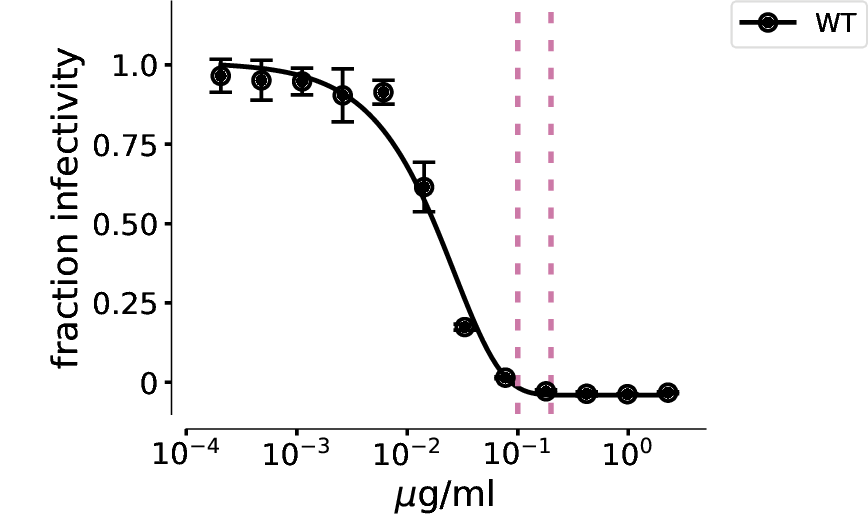

In [59]:
#Plotting neutralization curve for FI6v3
mut = ['WT']
color_cycle = ['k']
style_cycle = ['solid']
fit_cycle = [expo]
fmt_cycle = ['o']

PlotNeutralizationCurves(FI6v3_data, 'ug/ml_FI6v3', 
                         mut,
                         './plots/FI6v3_WT_neutralization_MAPlines.pdf', 
                         color_cycle=color_cycle,
                         style_cycle=style_cycle,
                         fit_cycle=fit_cycle,
                         fmt_cycle=fmt_cycle,
                         linewidth = 2.5,
                         fit_curve = True, 
                         verbose = True,
                         x_lim =[1E-4,5], y_lim = [-0.1,1.2], 
                         x_label_override='$\mu$g/ml', 
                         vlines = [0.1, 0.2])

showPDF('./plots/FI6v3_WT_neutralization_MAPlines.pdf')



curve-fitting info for  WT
fit parameters for curve:  [ 0.60772477 -5.01218206]
Threw an exception during fitting <function sigmoid at 0x7f432223b2f0> curve for WT


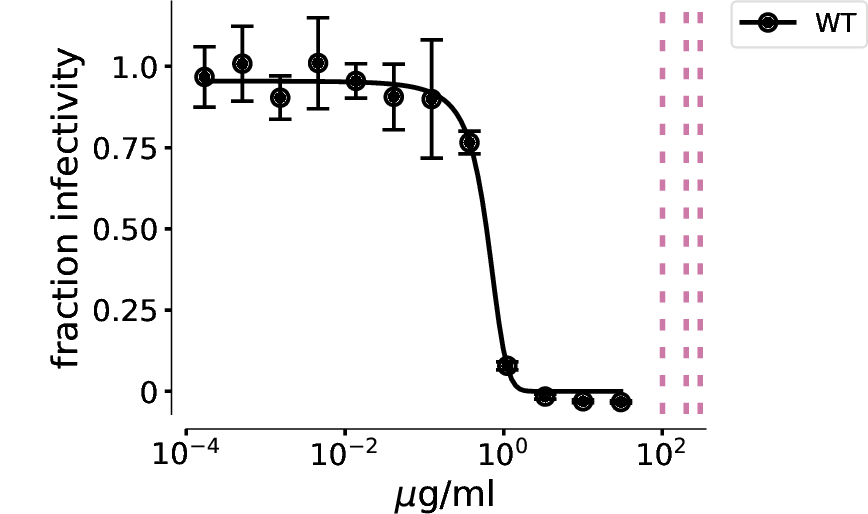

In [60]:
#Plotting neutralization curve for S139/1
mut = ['WT']
color_cycle = ['k']
style_cycle = ['solid']
fit_cycle = [sigmoid]
fmt_cycle = ['o']

PlotNeutralizationCurves(S139_data, 'ug/ml_S139', 
                         mut,
                         './plots/S139_WT_neutralization_MAPlines.pdf', 
                         color_cycle=color_cycle,
                         style_cycle=style_cycle,
                         fit_cycle=fit_cycle,
                         fmt_cycle=fmt_cycle,
                         linewidth = 2.5,
                         fit_curve = True, 
                         verbose = True,
                         x_lim =[1E-4,350], y_lim = [-0.07,1.2], 
                         x_label_override='$\mu$g/ml', 
                         vlines = [100, 200, 300])

showPDF('./plots/S139_WT_neutralization_MAPlines.pdf')



curve-fitting info for  WT
fit parameters for curve:  [ 1.01037794  1.59834094  0.02611233]
expo fit curve was used; here is the IC50 calculated from the fit parameters:  0.4082764756


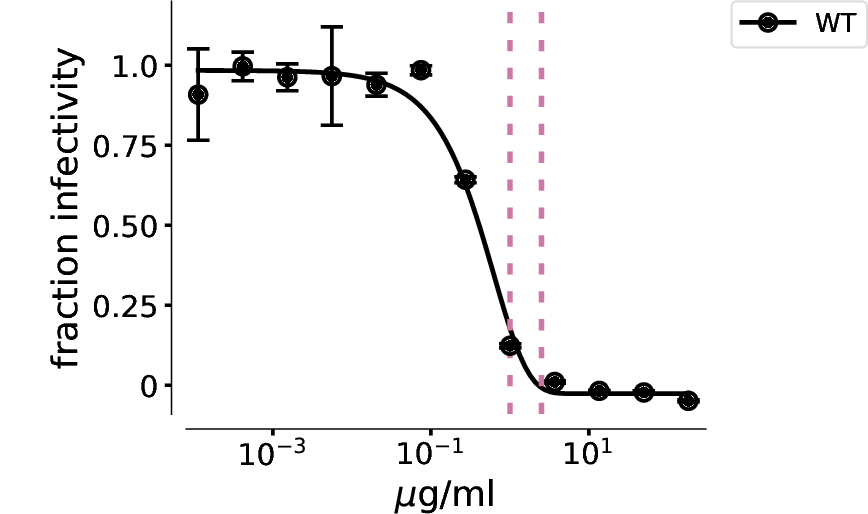

In [61]:
#Plotting neutralization curve for C179
mut = ['WT']
color_cycle = ['k']
style_cycle = ['solid']
fit_cycle = [expo]
fmt_cycle = ['o']

PlotNeutralizationCurves(C179_data, 'ug/ml_C179', 
                         mut,
                         './plots/C179_WT_neutralization_MAPlines.pdf', 
                         color_cycle=color_cycle,
                         style_cycle=style_cycle,
                         fit_cycle=fit_cycle,
                         fmt_cycle=fmt_cycle,
                         linewidth = 2.5,
                         fit_curve = True, 
                         verbose = True,
                         x_lim =[8E-5,300], y_lim = [-0.09,1.2], 
                         x_label_override='$\mu$g/ml', 
                         vlines = [1.0, 2.5])

showPDF('./plots/C179_WT_neutralization_MAPlines.pdf')



curve-fitting info for  WT
fit parameters for curve:  [  0.12087803 -41.12112758]
Threw an exception during fitting <function sigmoid at 0x7f432223b2f0> curve for WT


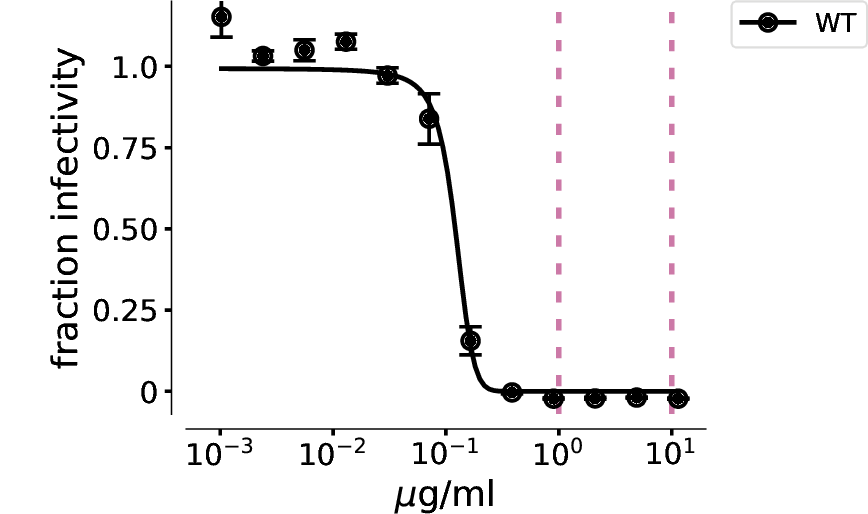

In [62]:
#Plotting neutralization curve for H17-L19
mut = ['WT']
color_cycle = ['k']
style_cycle = ['solid']
fit_cycle = [sigmoid]
fmt_cycle = ['o']

PlotNeutralizationCurves(H17L19_data, 'ug/ml_H17L19', 
                         mut,
                         './plots/H17L19_WT_neutralization_MAPlines.pdf', 
                         color_cycle=color_cycle,
                         style_cycle=style_cycle,
                         fit_cycle=fit_cycle,
                         fmt_cycle=fmt_cycle,
                         linewidth = 2.5,
                         fit_curve = True, 
                         verbose = True,
                         x_lim =[5E-4,20], y_lim = [-0.07,1.2], 
                         x_label_override='$\mu$g/ml', 
                         vlines = [1.0, 10])

showPDF('./plots/H17L19_WT_neutralization_MAPlines.pdf')



curve-fitting info for  WT
fit parameters for curve:  [  0.40991597 -11.36742869]
Threw an exception during fitting <function sigmoid at 0x7f432223b2f0> curve for WT


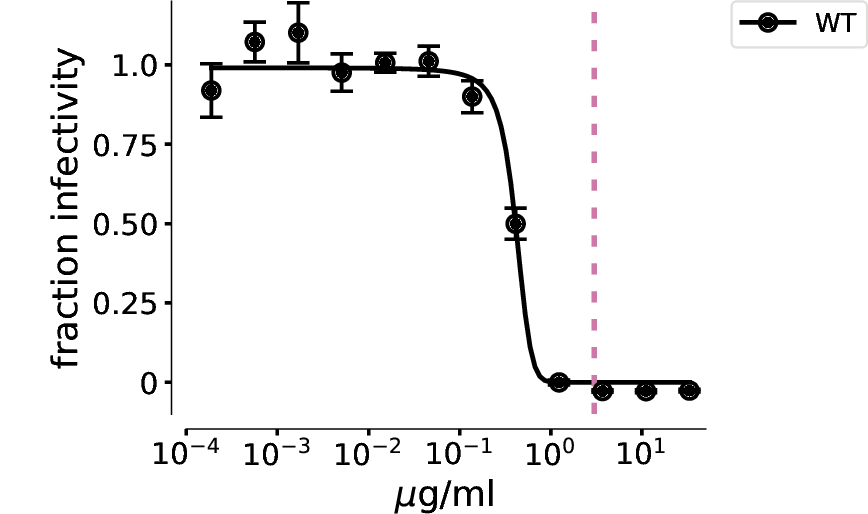

In [63]:
#Plotting neutralization curve for H17-L10
mut = ['WT']
color_cycle = ['k']
style_cycle = ['solid']
fit_cycle = [sigmoid]
fmt_cycle = ['o']

PlotNeutralizationCurves(H17L10_data, 'ug/ml_H17L10', 
                         mut,
                         './plots/H17L10_WT_neutralization_MAPlines.pdf', 
                         color_cycle=color_cycle,
                         style_cycle=style_cycle,
                         fit_cycle=fit_cycle,
                         fmt_cycle=fmt_cycle,
                         linewidth = 2.5,
                         fit_curve = True, 
                         verbose = True,
                         x_lim =[1E-4,50], y_lim = [-0.1,1.2], 
                         x_label_override='$\mu$g/ml', 
                         vlines = [3])

showPDF('./plots/H17L10_WT_neutralization_MAPlines.pdf')



curve-fitting info for  WT
fit parameters for curve:  [  0.38515497 -16.58573974]
Threw an exception during fitting <function sigmoid at 0x7f432223b2f0> curve for WT


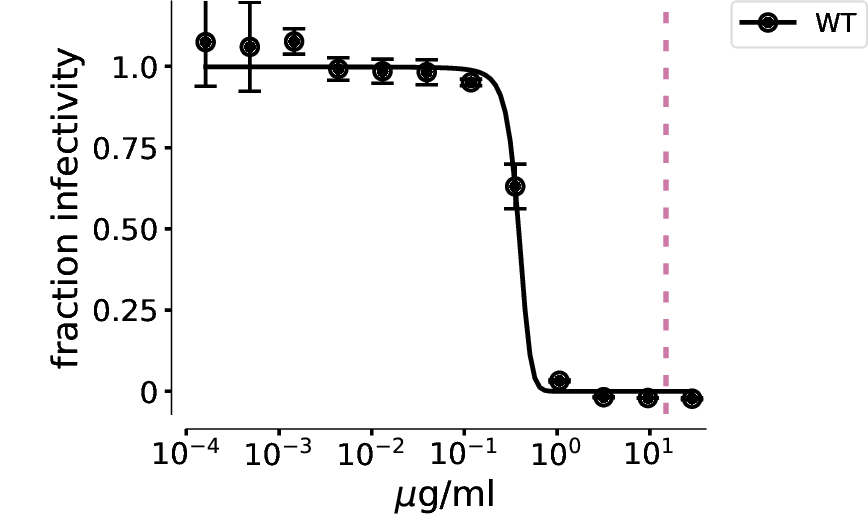

In [64]:
#Plotting neutralization curve for H17-L7
mut = ['WT']
color_cycle = ['k']
style_cycle = ['solid']
fit_cycle = [sigmoid]
fmt_cycle = ['o']

PlotNeutralizationCurves(H17L7_data, 'ug/ml_H17L7', 
                         mut,
                         './plots/H17L7_WT_neutralization_MAPlines.pdf', 
                         color_cycle=color_cycle,
                         style_cycle=style_cycle,
                         fit_cycle=fit_cycle,
                         fmt_cycle=fmt_cycle,
                         linewidth = 2.5,
                         fit_curve = True, 
                         verbose = True,
                         x_lim =[1E-4,40], y_lim = [-0.07,1.2], 
                         x_label_override='$\mu$g/ml', 
                         vlines = [15])

showPDF('./plots/H17L7_WT_neutralization_MAPlines.pdf')

In [ ]:
# Create FI6v3 mutants neutralization curves